<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

#Knowledge Entities Formation

In [21]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re

nlp = spacy.load("en_core_web_sm")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return None

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.coarse_graph = nx.Graph()
            return

        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.fine_graph = nx.Graph()
            return

        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|\[\]]'
        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        if not self.coarse_graph or not self.fine_graph:
            return None, None

        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=20, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    if data_coarse is None or data_fine is None:
        print("Graph data is not available due to lack of entities.")
        return None, None

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=10, lr=0.01)
    model = train_gat_model(model, data_fine, epochs=10, lr=0.01)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_vectors_coarse = model(data_coarse)
        contextual_vectors_fine = model(data_fine)

    return contextual_vectors_coarse, contextual_vectors_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Model Architecture

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_with_adapter_4 (Ro  (None, None, 768)            1247447   ['input_ids[0][0]',           
 bertaWithAdapter)                                        68         'attention_mask[0][0]']      
                                                                                            

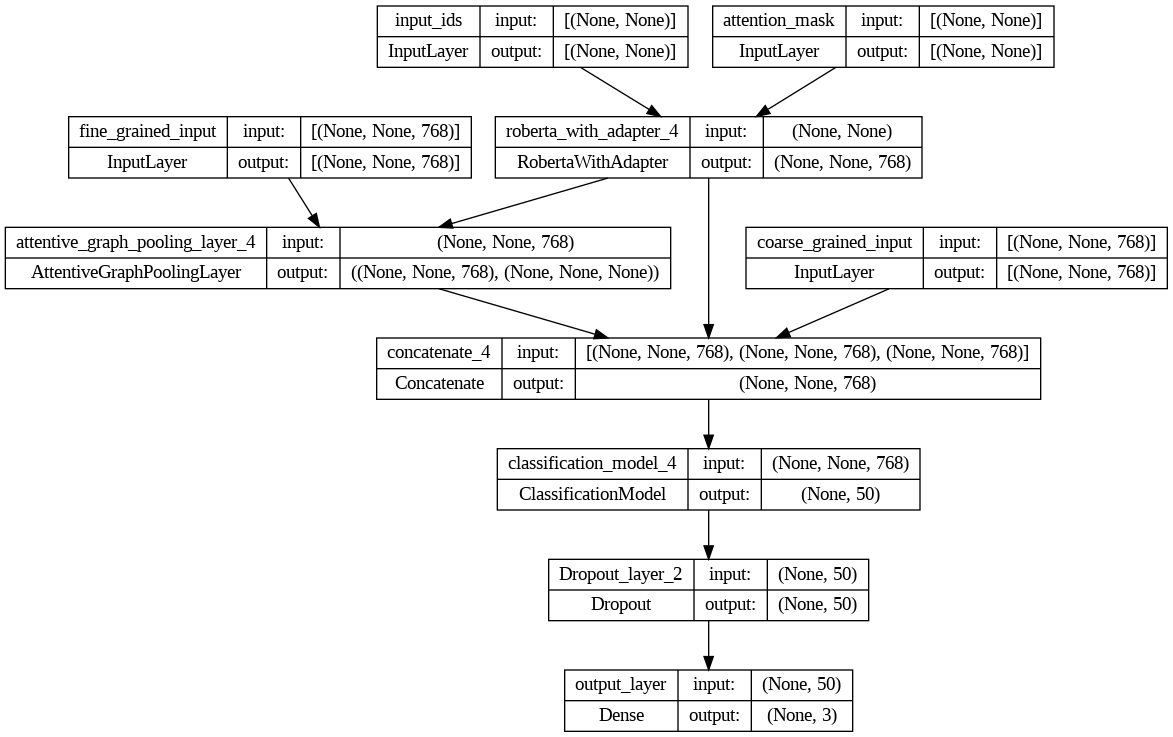

In [39]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import plot_model
import numpy as np

model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class ClassificationModel(tf.keras.Model):
    def __init__(self, max_sequence_length, combined_embedding_dim):
        super(ClassificationModel, self).__init__()
        self.conv1d = Conv1D(filters=256, kernel_size=5, activation='relu', name='Conv1D_layer')
        self.max_pooling = MaxPooling1D(pool_size=2, name='MaxPooling_layer')
        self.bilstm = Bidirectional(LSTM(100, return_sequences=True), name='BiLSTM_layer')
        self.attention = tf.keras.layers.Attention(name='Attention_layer')
        self.global_max_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')
        self.dense1 = Dense(100, activation='relu', name='Dense_layer_1')
        self.dropout1 = Dropout(0.6, name='Dropout_layer_1')
        self.dense2 = Dense(50, activation='relu', name='Dense_layer_2')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.max_pooling(x)
        x = self.bilstm(x)
        attention_output = self.attention([x, x])
        x = self.global_max_pooling(attention_output)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        adapter_output = self.adapter(sequence_output)
        return adapter_output

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        Q = self.WQ(h)
        K = self.WK(c)
        V = self.WV(c)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attended_values = tf.matmul(attn_weights, V)

        return attended_values, attn_weights


input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
fine_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='fine_grained_input')
coarse_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='coarse_grained_input')

roberta_with_adapter = RobertaWithAdapter(model_name, adapter_dim=64)
attention_layer = AttentiveGraphPoolingLayer(hidden_dim=768)
max_seq = roberta_with_adapter.roberta.config.max_position_embeddings
class_model = ClassificationModel(max_sequence_length=max_seq, combined_embedding_dim=768)

roberta_output = roberta_with_adapter(input_ids=input_ids, attention_mask=attention_mask)
attention_output, _ = attention_layer(fine_grained_input, roberta_output)


concatenated_input = Concatenate(axis=1)([roberta_output, attention_output, coarse_grained_input])

output_layer = class_model(concatenated_input)
dropout2 = Dropout(0.5, name='Dropout_layer_2')(output_layer)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

final_model = Model(inputs=[input_ids, attention_mask, fine_grained_input, coarse_grained_input], outputs=output_layer)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
final_model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss_fn, metrics=['accuracy'])

final_model.summary()
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
def get_input(input_text, model, tokenizer):
    roberta_input = tokenizer(input_text, return_tensors='tf', truncation=True, padding=True)
    contextual_vectors_coarse, contextual_vectors_fine = get_contextual_representations(input_text)
    return roberta_input, contextual_vectors_coarse, contextual_vectors_fine

In [13]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/UBC_project/cleaned_data_no_special_characters.csv' ,encoding='utf-8')
df.sample(10)

,claims,claims_labels
181,the idea that climate change be produce heat r...,REFUTES
6205,the earth be currently in an interglacial and ...,REFUTES
1461,also its not yet clear whether change in strat...,NOT_ENOUGH_INFO
5378,this ring effectively provide near unlimited p...,NOT_ENOUGH_INFO
992,cut speed limit could slow climate change,NOT_ENOUGH_INFO
7440,state lawmakers ban use recent climate science...,SUPPORTS
9636,the heat soar to 111 degree at UCLA the hot it...,SUPPORTS
9213,when future generation ask how the decision ma...,SUPPORTS
7375,Mayor Regalado hear the Plump administration s...,REFUTES
7181,of President Donald Plump who pull his country...,SUPPORTS


In [14]:
df = df[(df['claims'].str.split().str.len() > 3) & (df['claims'].str.split().str.len() < 20)]
df.shape

(3850, 2)

Balanced Class Distribution:
claims_labels
SUPPORTS           1099
NOT_ENOUGH_INFO    1099
REFUTES            1099
Name: count, dtype: int64


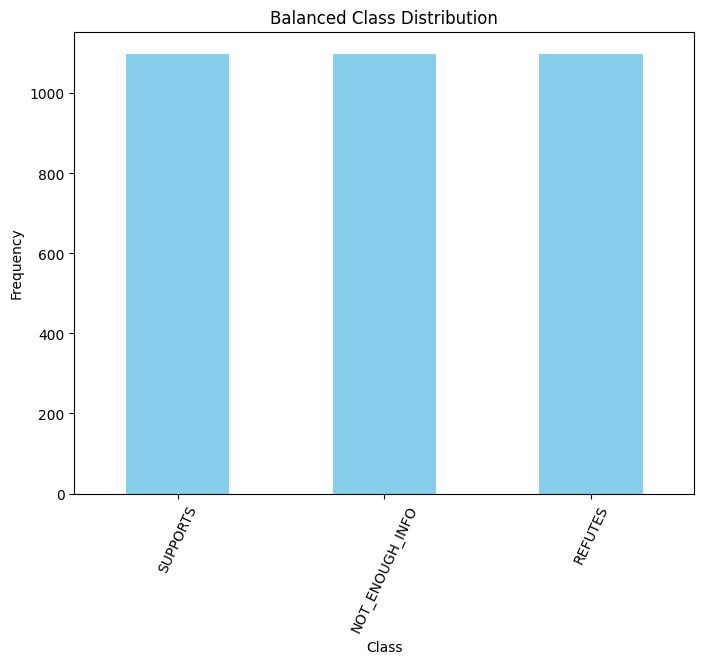

In [15]:
import matplotlib.pyplot as plt
min_class_size = min(df['claims_labels'].value_counts())

balanced_train_data = pd.DataFrame(columns=['claims','claims_labels'])

class_distribution = df['claims_labels'].value_counts()

for genre, count in class_distribution.items():
  class_data = df[df['claims_labels'] == genre].sample(n=min_class_size, random_state=22)
  balanced_train_data = pd.concat([balanced_train_data, class_data], ignore_index=True)

balanced_train_data.describe()
balanced_class_distribution = balanced_train_data['claims_labels'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)

plt.figure(figsize=(8, 6))
balanced_class_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

df = balanced_train_data


In [16]:
def ohe(text):

    if text=='SUPPORTS':
         return 2
    elif text=='NOT_ENOUGH_INFO':
         return 1
    elif text=='REFUTES' :
          return 0
    return 0

df['claims_labels']=df['claims_labels'].apply(lambda x:ohe(x))

df=df.sample(n=4,random_state=22)
df.shape

(4, 2)

In [17]:
df

,claims,claims_labels
1396,the ocean will never become acid because there...,1
3092,it be also the hot summer for England since re...,0
2130,lead global model produce quite different resu...,1
59,here be all the promising development ofll be ...,2


In [40]:
import numpy as np

input_ids = []
attention_masks = []
fine_grained_inputs = []
coarse_grained_inputs = []
labels = []
def generate_model_input(df, tokenizer):


  for index, row in df.iterrows():
    text = row['claims']
    label = row['claims_labels']
    roberta_input, contextual_vectors_coarse, contextual_vectors_fine = get_input(text, model, tokenizer)

    input_ids.append(roberta_input['input_ids'].numpy()[0])
    attention_masks.append(roberta_input['attention_mask'].numpy()[0])

    if contextual_vectors_fine is not None:
      fine_grained_inputs.append(contextual_vectors_fine.numpy())
    else:
      fine_grained_inputs.append(np.empty((0, 768)))

    if contextual_vectors_coarse is not None:
      coarse_grained_inputs.append(contextual_vectors_coarse.numpy())
    else:
      coarse_grained_inputs.append(np.empty((0, 768)))

    labels.append(label)


generate_model_input(df, tokenizer)


padded_input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding='post')
padded_attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, padding='post')
padded_fine_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(fine_grained_inputs, padding='post',dtype='float32')
padded_coarse_grained_inputs = tf.keras.preprocessing.sequence.pad_sequences(coarse_grained_inputs, padding='post',dtype='float32')

final_model.fit([padded_input_ids, padded_attention_masks, padded_fine_grained_inputs, padded_coarse_grained_inputs], np.array(labels), epochs=10,)

No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) England
England (en) data
{
  infobox: <dict(42)> image_flag, national_anthem, status, capital...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/England, h...
  pageid: 9316
  parsetree: <str(318573)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: England
  wikibase: Q21
  wikidata_url: https://www.wikidata.org/wiki/

Epoch 10/10, Loss: 1.0944420099258423
Epoch 10/10, Loss: 4.197984218597412
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.


en.wikipedia.org (parse) Paris
Paris (en) data
{
  image: <list(0)> 
  infobox: <dict(35)> name, commune status, image, image coat of a...
  iwlinks: <list(10)> https://commons.wikimedia.org/wiki/Paris, ht...
  pageid: 22989
  parsetree: <str(397639)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: Paris
  wikibase: Q90
  wikidata_url: https://www.wikidata.org/wiki/Q90
  wikitext: <str(251119)> {{Short description|Capital and largest ...
}
en.wikipedia.org (parse) this week
API error: {'code': 'missingtitle', 'info': "The page you specified doesn't exist.", 'docref': 'See https://en.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.'}


An error occurred: https://en.wikipedia.org/w/api.php?action=parse&formatversion=2&contentmodel=text&disableeditsection=&disablelimitreport=&disabletoc=&prop=text|iwlinks|parsetree|wikitext|displaytitle|properties&redirects&page=this%20week
Epoch 10/10, Loss: 9.630739212036133
Epoch 10/10, Loss: 48.98666000366211
Epoch 1/10


1/1 [==============================] - 88s 88s/step - loss: 1.1074 - accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 1.2780 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 1.0204 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 9s 9s/step - loss: 0.6550 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.7126 - accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 9s 9s/step - loss: 0.8083 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 0.7331 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 9s 9s/step - loss: 0.9781 - accuracy: 0.2500
Epoch 9/10
1/1 [==============================] - 6s 6s/step - loss: 1.1227 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 7s 7s/step - loss: 1.1027 - accuracy: 0.2500
